In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the project files
# project folder, e.g. 'time series metric learning'
FOLDERNAME = 'time series metric learning'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/time series metric learning


In [2]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 112kB 33.7MB/s 
     |████████████████████████████████| 89.4MB 31kB/s 


In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, utils, datasets
import torch.optim as optim
import torch.nn.functional as F
from dataset import TimeSeriesDataset, BalancedBatchSampler
from data_utils import load_project_dataset
from data_transformation import ToTensor, OneHotEncoding, Normalize,RandomHorizontalFlip
from torch.optim import lr_scheduler
from loss import OnlineTripletLoss
from data_utils import AllTripletSelector
from metrics import AverageNonzeroTripletsMetric
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from sklearn.manifold import TSNE



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    cuda=True
else:
    device = torch.device('cpu')
    cuda=False

print('using device:', device)

using device: cuda


In [5]:
label_multi='Label_multi'
label_binary='Label_binary'

fname="./dataset/project_dataset.csv"
data, labels = load_project_dataset(fname,label_multi)

print("data.shape: ", data.shape)
print("labels.shape: ", labels.shape)

data.shape:  (2997, 4, 1, 1007)
labels.shape:  (2997,)


In [6]:
dataset = TimeSeriesDataset(data = data, train=True, labels=labels)

#split the dataset in train/val/test
#ratio: 80/10/10
train_size = 2400
val_size = 300
test_size = 297


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size,test_size])


print("train_set: ",train_dataset.dataset.dataset[train_dataset.indices].shape)
unique, counts = np.unique(train_dataset.dataset.labels[train_dataset.indices], return_counts=True)
print("label train_set:",dict(zip(unique, counts)))
print("")
print("valid_set: ",valid_dataset.dataset.dataset[valid_dataset.indices].shape)
unique, counts = np.unique( valid_dataset.dataset.labels[valid_dataset.indices], return_counts=True)
print("label valid_set:",dict(zip(unique, counts)))
print("")
print("test_set: ",test_dataset.dataset.dataset[test_dataset.indices].shape)
unique, counts = np.unique( test_dataset.dataset.labels[test_dataset.indices], return_counts=True)
print("label test_set:",dict(zip(unique, counts)))


train_set:  (2400, 4, 1, 1007)
label train_set: {0: 530, 1: 837, 2: 157, 3: 876}

valid_set:  (300, 4, 1, 1007)
label valid_set: {0: 69, 1: 88, 2: 21, 3: 122}

test_set:  (297, 4, 1, 1007)
label test_set: {0: 67, 1: 104, 2: 11, 3: 115}


In [7]:
#compute statistichs on the training set
mean_train=()
std_train=()
dim=4

for i in range (0,dim):
  mean=np.mean(train_dataset.dataset.dataset[train_dataset.indices][:,i,:])
  std=np.std(train_dataset.dataset.dataset[train_dataset.indices][:,i,:])
  mean_train += (mean, )
  std_train += (std, )

print("mean_train: ", mean_train)
print("std_train: ", std_train)


mean_train:  (-0.9534525780118557, 1.84001667952983, -8.635518563629587, 2.766804653749729)
std_train:  (1.0237632545389155, 1.1765207144577838, 0.48442166890116656, 7.8212244328394185)


In [8]:
#define data transformation: ToTensor -> Normalize
composed_transf = transforms.Compose([
                                      ToTensor(), #transform data and labels into tensors
                                      #RandomHorizontalFlip(p=0.3),
                                      Normalize(mean_train, std_train),  #normalize each dimension
                                     ])


transformed_train_dataset = TimeSeriesDataset(data = train_dataset.dataset.dataset[train_dataset.indices], 
                                              labels = train_dataset.dataset.labels[train_dataset.indices], 
                                              transform = composed_transf,
                                              train=True)

transformed_valid_dataset = TimeSeriesDataset(data = valid_dataset.dataset.dataset[valid_dataset.indices], 
                                              labels = valid_dataset.dataset.labels[valid_dataset.indices], 
                                              transform = composed_transf,
                                              train=False)

transformed_test_dataset = TimeSeriesDataset(data = test_dataset.dataset.dataset[test_dataset.indices], 
                                             labels = test_dataset.dataset.labels[test_dataset.indices], 
                                             transform = composed_transf,
                                             train=False)


#batch_size=40
n_classes = 4
n_samples = 10
print("dim batch:", n_classes*n_samples)
print("-num classes:", n_classes)
print("-num sample per class:", n_samples)
print("")

train_balanced_batch_sampler = BalancedBatchSampler(transformed_train_dataset.labels, n_classes, n_samples)
valid_balanced_batch_sampler = BalancedBatchSampler(transformed_valid_dataset.labels, n_classes, n_samples)
test_balanced_batch_sampler = BalancedBatchSampler(transformed_test_dataset.labels, n_classes, n_samples)

train_loader = DataLoader(transformed_train_dataset, batch_sampler=train_balanced_batch_sampler)
valid_loader = DataLoader(transformed_valid_dataset, batch_sampler=valid_balanced_batch_sampler)
test_loader= DataLoader(transformed_test_dataset, batch_sampler=test_balanced_batch_sampler)


print("num train batches:",len(train_loader))
for i_batch, (serie,label) in enumerate(train_loader):
  if i_batch <= 1:
    print("batch",i_batch, serie.size(), label.size())
    print(label)


dim batch: 40
-num classes: 4
-num sample per class: 10

num train batches: 60
batch 0 torch.Size([40, 4, 1, 1007]) torch.Size([40])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
batch 1 torch.Size([40, 4, 1, 1007]) torch.Size([40])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convnet = nn.Sequential(nn.Conv1d(4, 64, 3,stride=1,padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool1d(2),
                                     nn.Conv1d(64, 64, 3,stride=1,padding=1),
                                     nn.BatchNorm1d(64), 
                                     nn.ReLU(),
                                     nn.MaxPool1d(4),)

        self.fc = nn.Sequential(nn.Linear(8000, 256),  
                                nn.BatchNorm1d(256),                                                   
                                nn.ReLU(),
                                nn.Dropout(0.1),  
                                nn.Linear(256, 128),)

    def forward(self, x):
        x=  x.float()
        x = flatten2(x)
        x = self.convnet(x)
        x = flatten1(x)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)

        return x

    def get_embedding(self, x):
        return self.forward(x)



def flatten1(x):
  N = x.shape[0] # read in N, C, H, W
  return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


def flatten2(x):
  N = x.shape[0] # read in N, C, H, W
  C = x.shape[1]
  HW = x.shape[2]*x.shape[3]
  return x.view((N,C,HW))  # "flatten" the  H * W values into a single vector per image


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train(model, loss_fn, optimizer, epoch, n_epochs, metrics=[]):

    for metric in metrics:
      metric.reset()

    #scheduler.step()
    total_loss = 0
    losses = []
    print("Lr=",get_lr(optimizer))
    for batch_idx, (data, labels) in enumerate(train_loader):
        model.train()  # put model to training mode
        data, labels = data.to(device), labels.to(device)
        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()
        embeddings = model(data)
        
        loss_outputs = loss_fn(embeddings, labels)
        loss= loss_outputs[0]
            
        total_loss += loss.item()
        losses.append(loss.item())
        
        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()

        for metric in metrics:
          metric(embeddings, labels, loss_outputs)
        
        loss_history_train.append(loss)
        if batch_idx % 120 == 0:
          losses=[]
                        
    total_loss /= (batch_idx + 1)    

    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch, n_epochs, total_loss)
      
    for metric in metrics:
      message += '\t{}: {}'.format(metric.name(), metric.value())

    val_loss, metrics = test_epoch(valid_loader, model, loss_fn, metrics)
    val_loss /= len(valid_loader)
    loss_history_valid.append(val_loss)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch, n_epochs, val_loss)

    scheduler.step(val_loss)
        
    for metric in metrics:
        message += '\t{}: {}'.format(metric.name(), metric.value())
        
    print(message)
    
    #test_train(transformed_train_dataset, transformed_train_dataset, model,  AccuracyCalculator(include = ("precision_at_1",), k = 1))
    #test_valid(transformed_train_dataset, transformed_valid_dataset, model,  AccuracyCalculator(include = ("precision_at_1",), k = 1))



def test_epoch(dataloader, model, loss_fn, metrics):
    with torch.no_grad():
        for metric in metrics:
          metric.reset()

        model.eval()
        val_loss = 0
        for batch_idx, (data, labels) in enumerate(dataloader):
            data, labels = data.to(device), labels.to(device)

            embeddings = model(data)
            loss_outputs = loss_fn(embeddings, labels)
            loss= loss_outputs[0]
            val_loss += loss.item()

            for metric in metrics:
                metric(embeddings, labels, loss_outputs)

    return val_loss,metrics


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test_valid(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels=torch.reshape(train_labels, (-1,))
    test_labels=torch.reshape(test_labels, (-1,))
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    #print("Val set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    #acc_history_valid.append(accuracies["precision_at_1"])
    print("NMI: ",accuracies["NMI"])
    print("MaP: ",accuracies["mean_average_precision"])

def test_train(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels=torch.reshape(train_labels, (-1,))
    test_labels=torch.reshape(test_labels, (-1,))
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                True)
    #print("Train set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    #acc_history_train.append(accuracies["precision_at_1"])
    print("NMI: ",accuracies["NMI"])
    print("MaP: ",accuracies["mean_average_precision"])


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
classes = ["0 (OK)","1 (SO SO)","2 (PRE-WARNING)","3 (ALARM)"]
#classes = ["0 (OK)","1 (ALARM)"]


def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

In [11]:
model=Net()
model.to(device)

loss_history_train=[]
loss_history_valid=[]
acc_history_valid=[]
acc_history_train=[]

margin= 1.
loss_fn = OnlineTripletLoss(margin, AllTripletSelector())
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.85)

num_epochs = 150
for epoch in range(1, num_epochs+1):
    train(model, loss_fn, optimizer, epoch,  num_epochs, metrics=[AverageNonzeroTripletsMetric()])

Lr= 0.0001
Epoch: 1/150. Train set: Average loss: 0.7086	Average nonzero triplets: 5400.0
Epoch: 1/150. Validation set: Average loss: 0.6536	Average nonzero triplets: 5400.0
Lr= 0.0001
Epoch: 2/150. Train set: Average loss: 0.6519	Average nonzero triplets: 5400.0
Epoch: 2/150. Validation set: Average loss: 0.5872	Average nonzero triplets: 5400.0
Lr= 0.0001
Epoch: 3/150. Train set: Average loss: 0.5885	Average nonzero triplets: 5400.0
Epoch: 3/150. Validation set: Average loss: 0.5318	Average nonzero triplets: 5400.0
Lr= 0.0001
Epoch: 4/150. Train set: Average loss: 0.5521	Average nonzero triplets: 5400.0
Epoch: 4/150. Validation set: Average loss: 0.5344	Average nonzero triplets: 5400.0
Lr= 0.0001
Epoch: 5/150. Train set: Average loss: 0.5328	Average nonzero triplets: 5400.0
Epoch: 5/150. Validation set: Average loss: 0.4997	Average nonzero triplets: 5400.0
Lr= 0.0001
Epoch: 6/150. Train set: Average loss: 0.5089	Average nonzero triplets: 5400.0
Epoch: 6/150. Validation set: Average lo

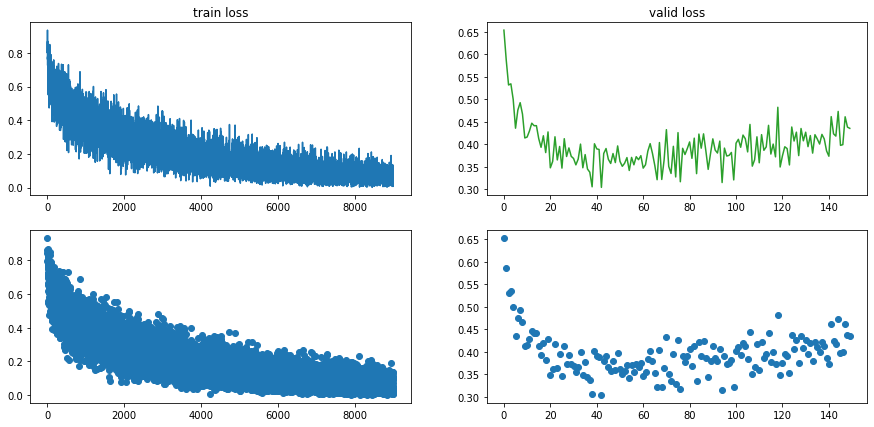

In [12]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15, 7)

axs[0, 0].set_title("train loss")
axs[0, 0].plot(loss_history_train)
axs[0, 1].set_title("valid loss")
axs[0, 1].plot(loss_history_valid,'tab:green')

axs[1,0].plot(loss_history_train, 'o')
axs[1,1].plot(loss_history_valid, 'o')

In [ ]:
#plt.subplot(2, 1, 1)
#plt.plot(loss_history_train, 'o')
#plt.xlabel('iteration')
#plt.ylabel('loss')

#plt.subplot(2, 1, 2)
#plt.plot(acc_history_train, '-o')
#plt.plot(acc_history_valid, '-o')
#plt.legend(['train', 'val'], loc='upper left')
#plt.xlabel('epoch')
#plt.ylabel('accuracy')
#plt.show()

100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


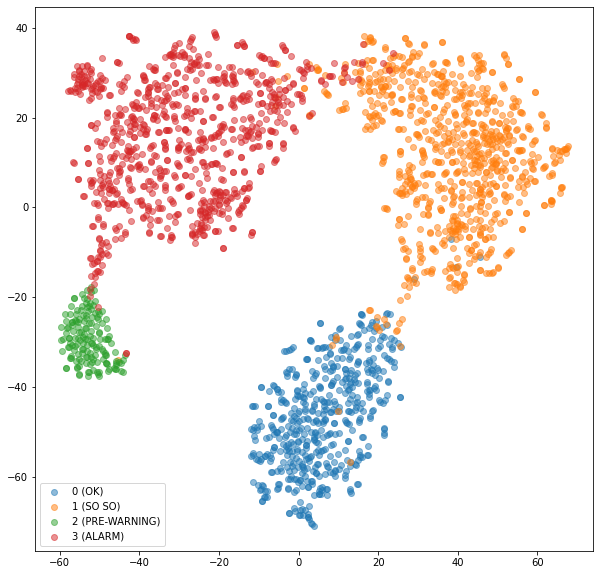

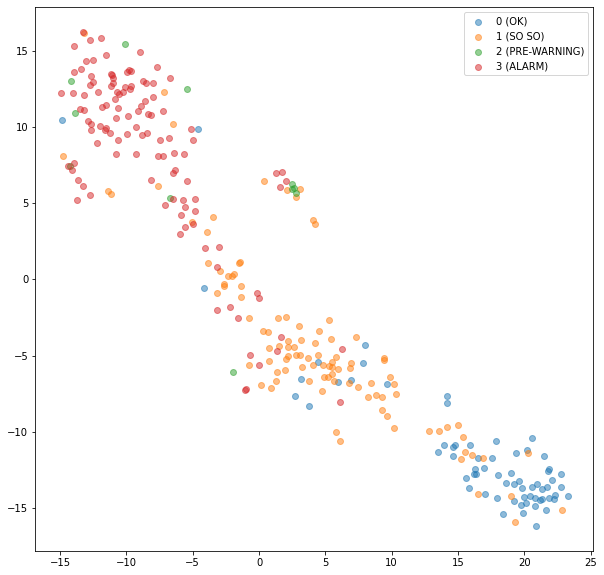

In [13]:
tsne = TSNE(n_components=2)
train_embeddings, train_labels = get_all_embeddings(transformed_train_dataset, model)
test_embeddings, test_labels = get_all_embeddings(transformed_test_dataset, model)

train_embeddings=train_embeddings.cpu().numpy()
train_labels=train_labels.cpu().numpy()

test_embeddings=test_embeddings.cpu().numpy()
test_labels=test_labels.cpu().numpy()

train_embeddings_2d = tsne.fit_transform(train_embeddings)
plot_embeddings(train_embeddings_2d, train_labels)

test_embeddings_2d = tsne.fit_transform(test_embeddings)
plot_embeddings(test_embeddings_2d, test_labels)


In [14]:
from sklearn.neighbors import KNeighborsClassifier

for k in [1,3,5,10,12,20]:
  neigh = KNeighborsClassifier(n_neighbors=k, p=2)
  neigh.fit(train_embeddings, train_labels)

  predict=neigh.predict(test_embeddings)

  score=neigh.score(test_embeddings, test_labels)

  print('K = {}   Score: {:.4f}'.format(k, score))

K = 1   Score: 0.7508
K = 3   Score: 0.7609
K = 5   Score: 0.7609
K = 10   Score: 0.7643
K = 12   Score: 0.7643
K = 20   Score: 0.7677


In [15]:
test_valid(transformed_train_dataset, transformed_test_dataset, model,  AccuracyCalculator(include = ("mean_average_precision","NMI",),k=3))

100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Computing accuracy
NMI:  0.4378457798916546
MaP:  0.7878787878787877
